# Модуль 9. **Підбір гіперпараметрів НМ**

In [220]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [221]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [222]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [223]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [224]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}

labels = pd.DataFrame(labels_description)

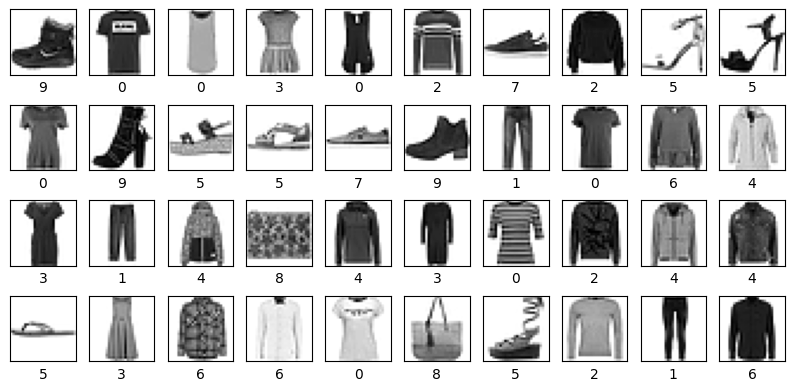

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [225]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

    Функція друку поточних параметрів

In [226]:
def print_parameters(parameters: dict, text_='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text_}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат

In [227]:
def plt_history(history, params):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(params)
    
    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Базова модель

In [228]:
# TODO розібратися
# # Визначте вхідний шар
# inputs = Input(shape=(28, 28))

# # Додайте шари до моделі
# x = layers.Flatten()(inputs)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# outputs = layers.Dense(10, activation="softmax")(x)

# # Створіть модель
# model = Model(inputs, outputs)

In [229]:
# заглушка - щоб прибрати UserWarning
# model_ = models.Sequential(
#     [
#         layers.Flatten(input_shape=(28, 28)),
#         # Do not pass an `input_shape`/`input_dim` argument to a layer. 
#         # When using Sequential models, prefer using an `Input(shape)` object 
#         # as the first layer in the model instead.
#         layers.Dense(128, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

# model_.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

# history = model_.fit(
#     train_images,
#     train_labels,
#     epochs=10,
#     batch_size=128,
#     validation_split=0.2,
#     verbose=0,
# )

# plt_history(
#     history,
#     {
#         "epochs": 10,
#         "batch_size": 128,
#         "dropout_rate": 0.2,
#         "loss_function": "sparse_categorical_crossentropy",
#         "optimizer": "adam",
#         "hidden_units": 128,
#         "activation": "relu",
#         "metrics": ["accuracy"],
#     },
# )

# model.save("my_model.keras")

**Функція пошуку оптимальних параметрів**

      Аргументи: 
1. Набори даних для навчання і валідації
2. Параметри для тренування моделі
3. Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні.
4. Послідовність параметрів, що мають перевірятися.
5. Функція, що містить модель для тренування

In [230]:
def find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)
            model, history, test_acc, train_acc = train_model_func(
                train_images,
                train_labels,
                test_images,
                test_labels,
                verbose=verbose,
                **optimal_parameters,
            )
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [231]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 64,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    # "epochs": [10, 20, 50],
    "epochs": [10, 20, 50, 100],
    # "batch_size": [64, 128],
    "batch_size": [32, 64, 128, 256],
    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],
    # "optimizer": ["adam", "rmsprop"],
    "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    "hidden_units": [64, 128, 256],
    # "activation": ["relu", "sigmoid"],
    "activation": ["relu", "sigmoid", "tanh"],
    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

In [232]:
def train_model_1(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0
):
    model = models.Sequential(
        [
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(hidden_units, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

**Параметри, для навчання моделі 1**


Послідовність дослідження - **study_sequence**

In [233]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------


c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step - accuracy: 0.9070 - loss: 0.2516
          тренувальні дані:   0.9052333235740662 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8770 - loss: 0.3483
          тестові дані:       0.8741999864578247 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


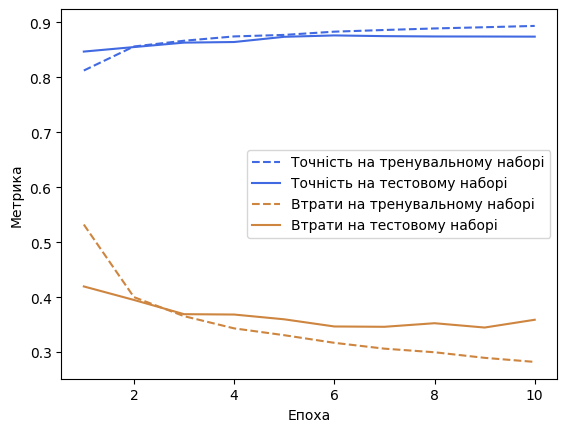

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step - accuracy: 0.9073 - loss: 0.2495
          тренувальні дані:   0.9081500172615051 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.8825 - loss: 0.3369
          тестові дані:       0.8801000118255615 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


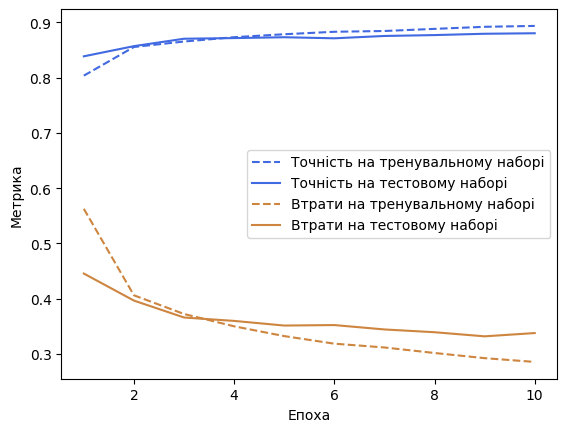

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.9102 - loss: 0.2461
          тренувальні дані:   0.9098833203315735 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.8792 - loss: 0.3281
          тестові дані:       0.8809999823570251 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


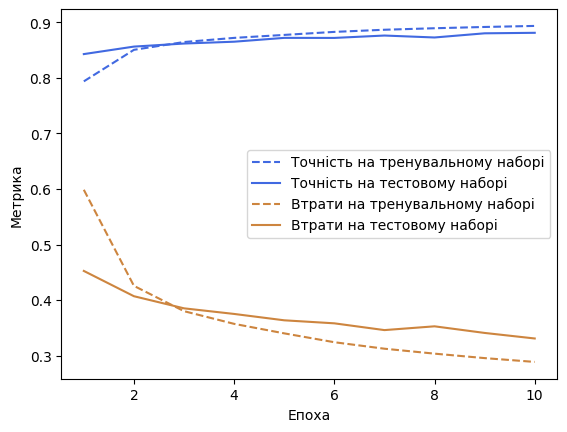

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - accuracy: 0.8997 - loss: 0.2717
          тренувальні дані:   0.8991333246231079 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8776 - loss: 0.3367
          тестові дані:       0.8745999932289124 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


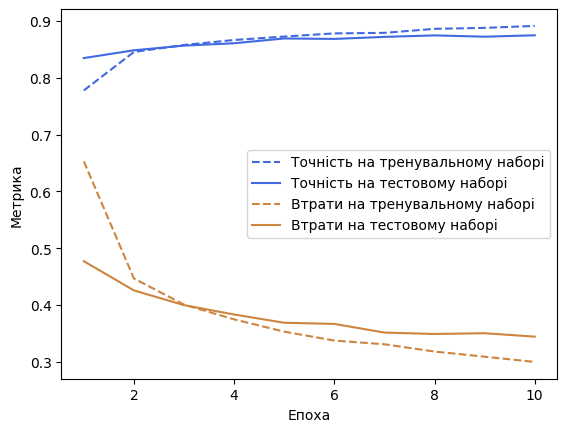

 Оптимальне значення параметра batch_size = 128
   точність на тестових даних: 0.8809999823570251

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9043 - loss: 0.2581
          тренувальні дані:   0.9038000106811523 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.8782 - loss: 0.3466
          тестові дані:       0.8765000104904175 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


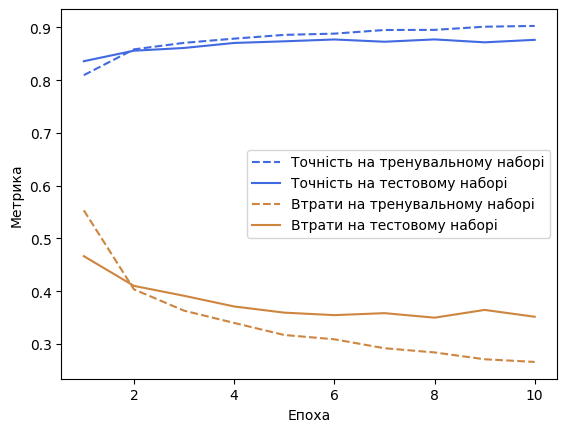

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.9086 - loss: 0.2486
          тренувальні дані:   0.9086166620254517 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.8813 - loss: 0.3333
          тестові дані:       0.8802000284194946 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


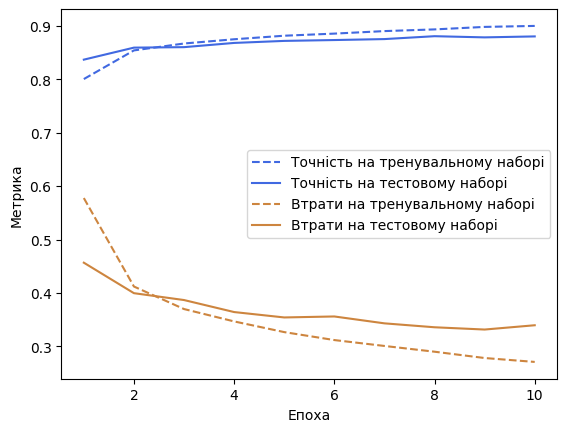

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9117 - loss: 0.2428
          тренувальні дані:   0.9105166792869568 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.8790 - loss: 0.3278
          тестові дані:       0.8805999755859375 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


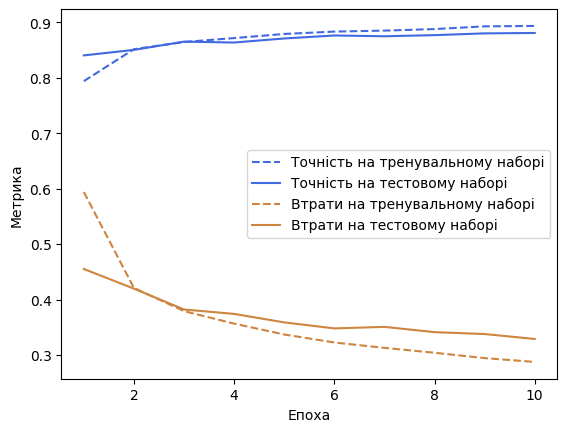

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.9028 - loss: 0.2659
          тренувальні дані:   0.9021999835968018 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8796 - loss: 0.3357
          тестові дані:       0.8777999877929688 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


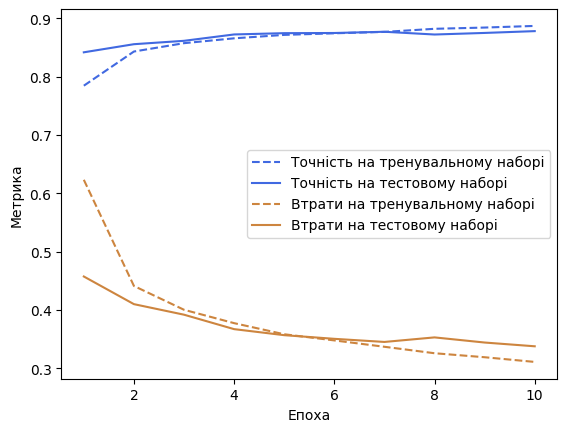

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8809999823570251

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.8976 - loss: 0.2798
          тренувальні дані:   0.8970999717712402 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.8724 - loss: 0.3511
          тестові дані:       0.8729000091552734 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


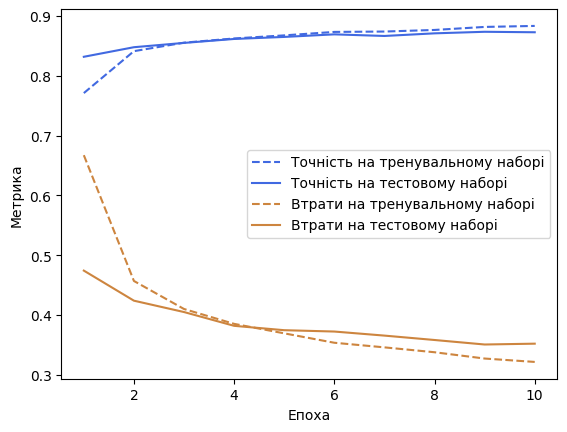

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.9059 - loss: 0.2548
          тренувальні дані:   0.904699981212616 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.8794 - loss: 0.3340
          тестові дані:       0.8784999847412109 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


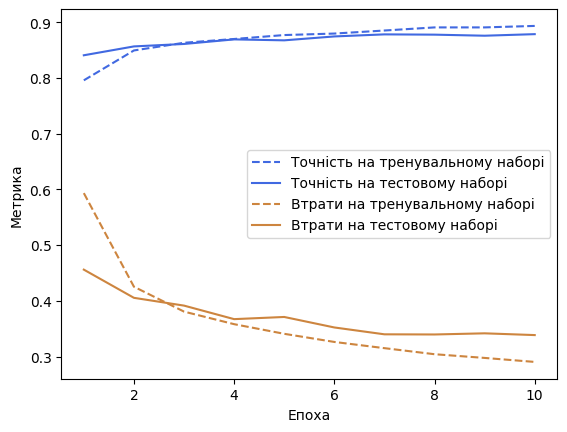

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.9091 - loss: 0.2439
          тренувальні дані:   0.9068499803543091 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8782 - loss: 0.3311
          тестові дані:       0.8765000104904175 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


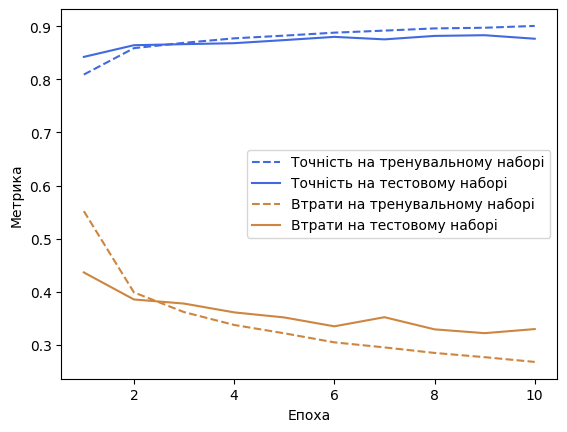

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.8809999823570251

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 863us/step - accuracy: 0.9096 - loss: 0.2516
          тренувальні дані:   0.9091500043869019 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.8818 - loss: 0.3242
          тестові дані:       0.8809000253677368 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


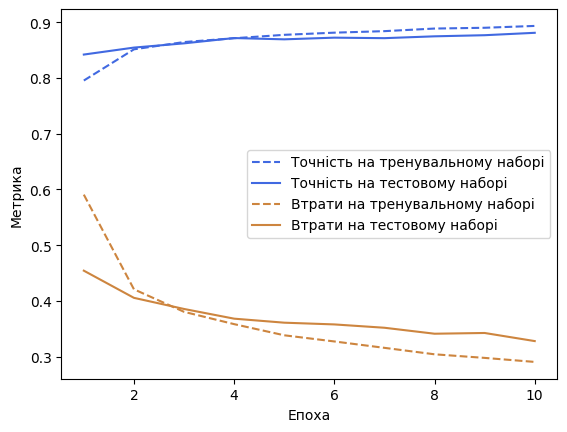

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.9084 - loss: 0.2482
          тренувальні дані:   0.9076499938964844 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.8817 - loss: 0.3328
          тестові дані:       0.8809000253677368 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


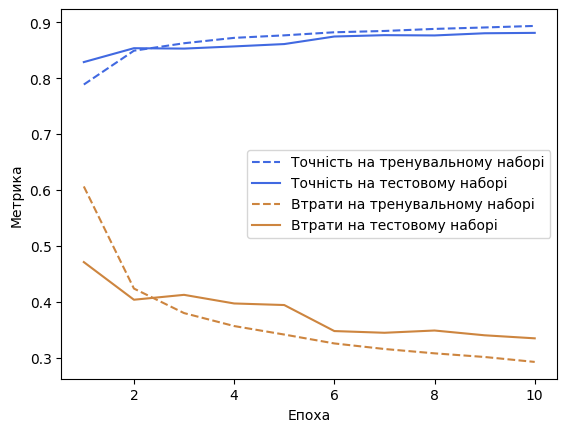

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.8466 - loss: 0.4589
          тренувальні дані:   0.8442999720573425 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.8357 - loss: 0.4846
          тестові дані:       0.8303999900817871 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


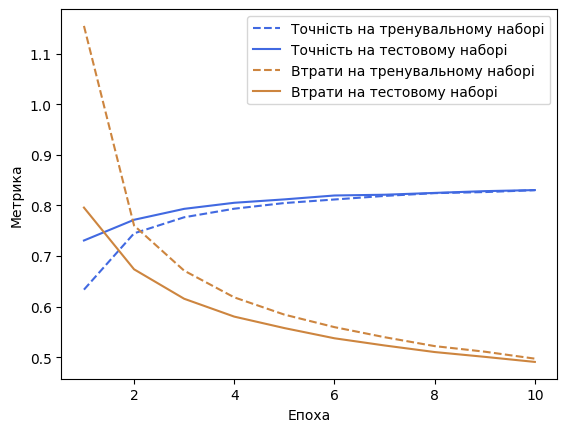

--------------------------------------------------
Тестується значення: optimizer = adagrad
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.7999 - loss: 0.6230
          тренувальні дані:   0.7995333075523376 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.6385  
          тестові дані:       0.7883999943733215 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adagrad
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


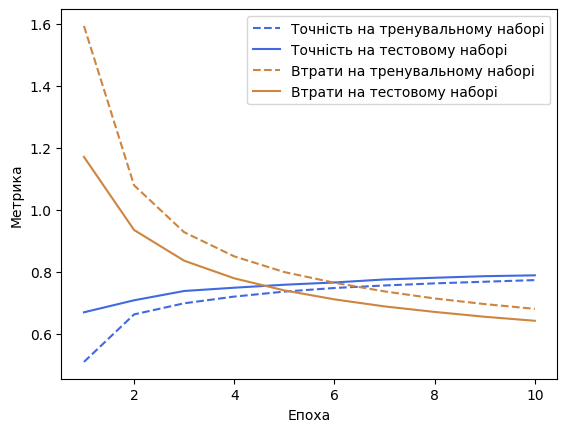

--------------------------------------------------
Тестується значення: optimizer = adadelta
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.6343 - loss: 1.3495
          тренувальні дані:   0.6362000107765198 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 1.3538
          тестові дані:       0.6281999945640564 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adadelta
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


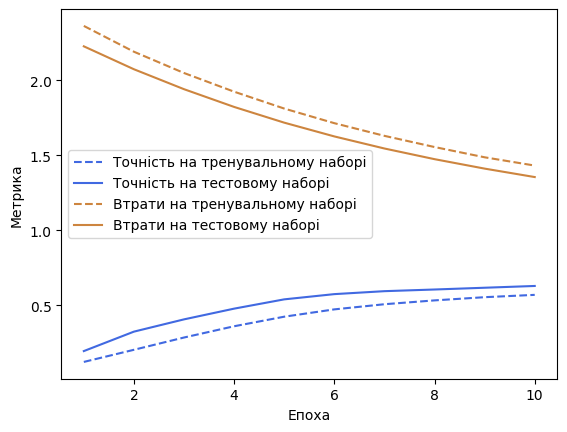

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.8809999823570251

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9064 - loss: 0.2530
          тренувальні дані:   0.9061333537101746 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.8802 - loss: 0.3325
          тестові дані:       0.8802000284194946 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


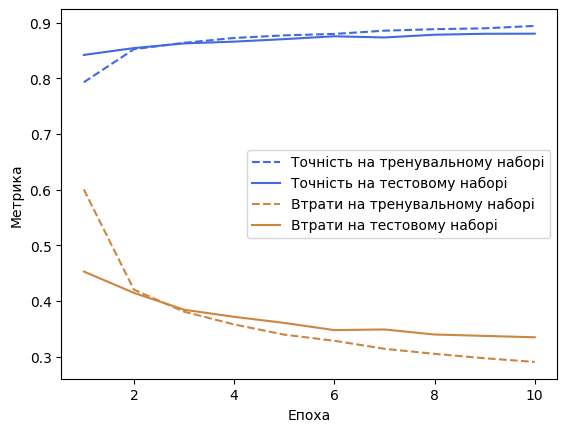

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - accuracy: 0.8916 - loss: 0.2984
          тренувальні дані:   0.8918833136558533 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.8757 - loss: 0.3539
          тестові дані:       0.8719000220298767 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']


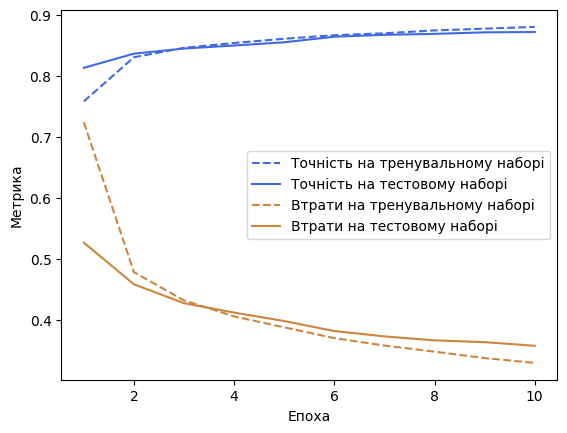

--------------------------------------------------
Тестується значення: activation = tanh
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.8960 - loss: 0.2804
          тренувальні дані:   0.8967833518981934 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8733 - loss: 0.3488
          тестові дані:       0.8720999956130981 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= tanh
 metrics 	= ['accuracy']


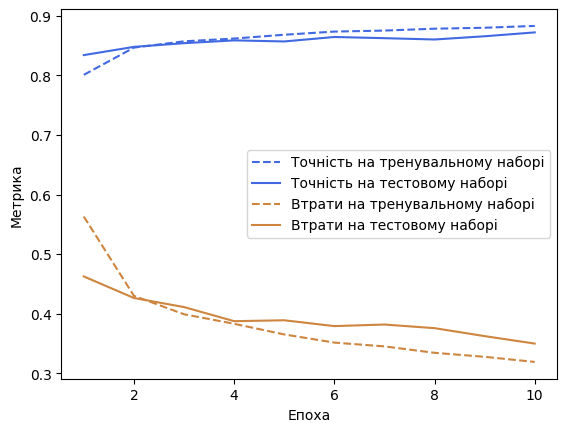

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.8809999823570251

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.9044 - loss: 0.2553
          тренувальні дані:   0.90420001745224 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8802 - loss: 0.3300  
          тестові дані:       0.8790000081062317 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


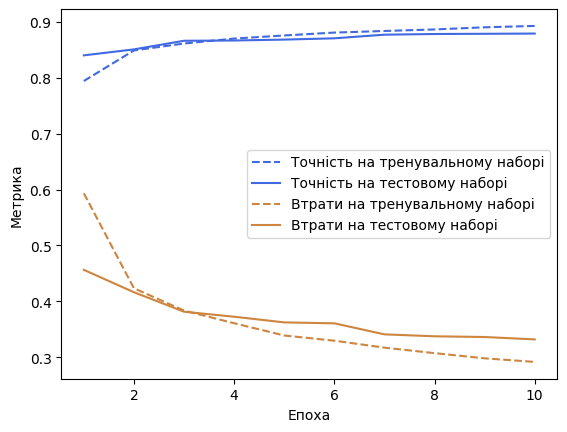

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.9222 - loss: 0.2083
          тренувальні дані:   0.921583354473114 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8901 - loss: 0.3211
          тестові дані:       0.8888999819755554 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


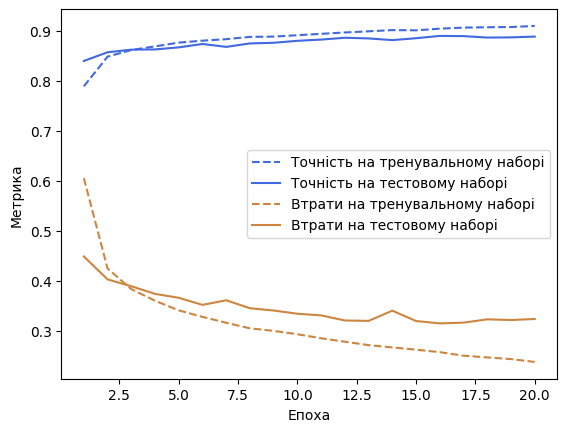

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.9555 - loss: 0.1245
          тренувальні дані:   0.9552833437919617 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8914 - loss: 0.3397
          тестові дані:       0.892300009727478 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


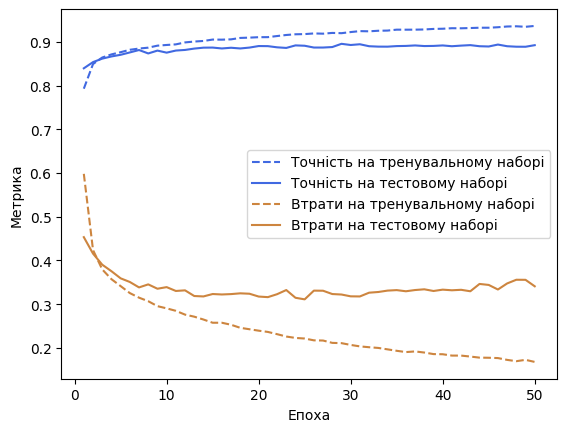

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9721 - loss: 0.0781
          тренувальні дані:   0.9710333347320557 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.8918 - loss: 0.4342
          тестові дані:       0.8906000256538391 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


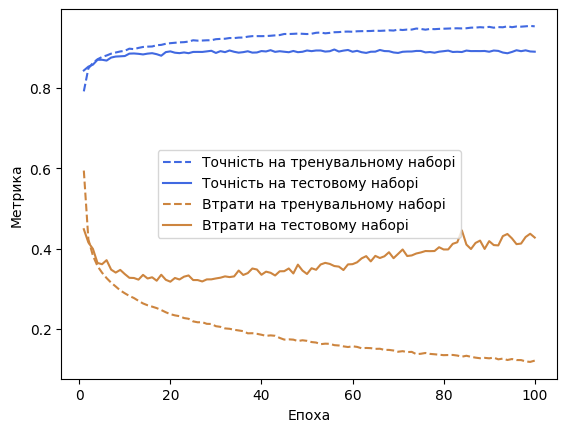

 Оптимальне значення параметра epochs = 50
   точність на тестових даних: 0.892300009727478



In [234]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_1,
)

In [235]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.892300009727478


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>0.8923</b>) недостатня</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових Dense-шари (3 та 4)_

     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 2 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
4. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 4 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
5. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [236]:
def train_model_2(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0,
):

    model = models.Sequential(
        [
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(hidden_units, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(int(hidden_units / 2), activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(int(hidden_units / 4), activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    # print("Точність на тренувальних даних:", train_acc)
    print("   тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    # print("Точність на тестових даних:", test_acc)
    print("   тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

In [237]:
study_sequence = [
    # "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9704 - loss: 0.0786
   тренувальні дані:   0.9695666432380676 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8854 - loss: 0.4876
   тестові дані:       0.8848999738693237 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


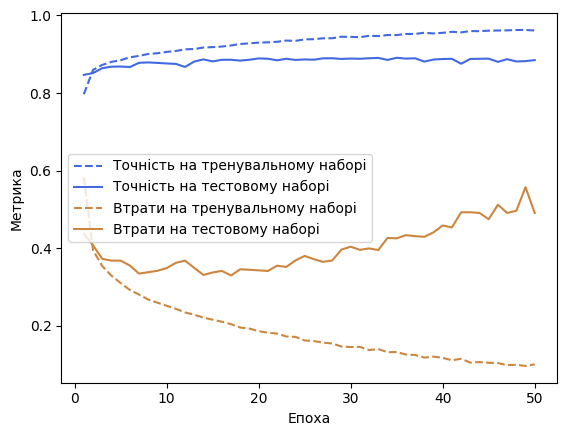

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9474 - loss: 0.1353
   тренувальні дані:   0.9466999769210815 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8943 - loss: 0.3629
   тестові дані:       0.8931999802589417 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


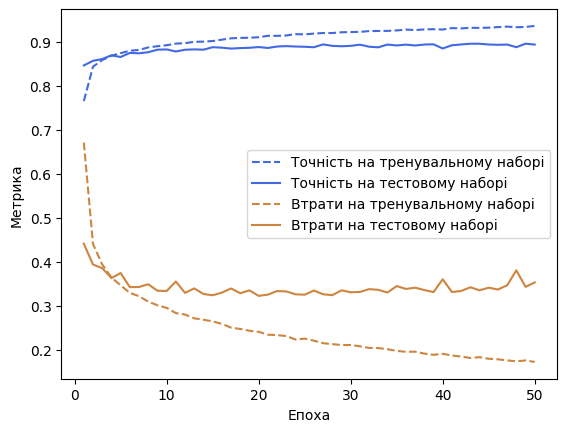

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.9366 - loss: 0.1677
   тренувальні дані:   0.9355499744415283 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.8924 - loss: 0.3364
   тестові дані:       0.8914999961853027 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


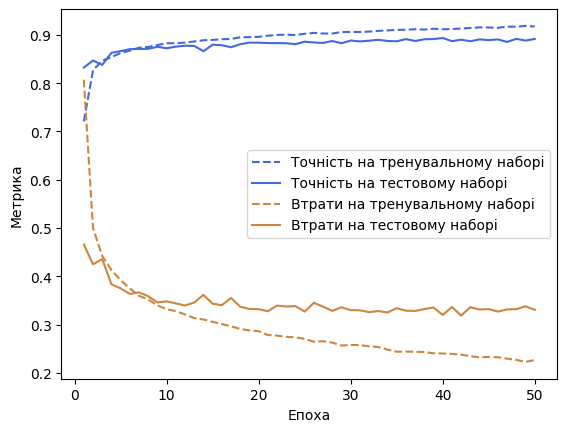

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step - accuracy: 0.9261 - loss: 0.1945
   тренувальні дані:   0.9249666929244995 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8848 - loss: 0.3473
   тестові дані:       0.8849999904632568 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


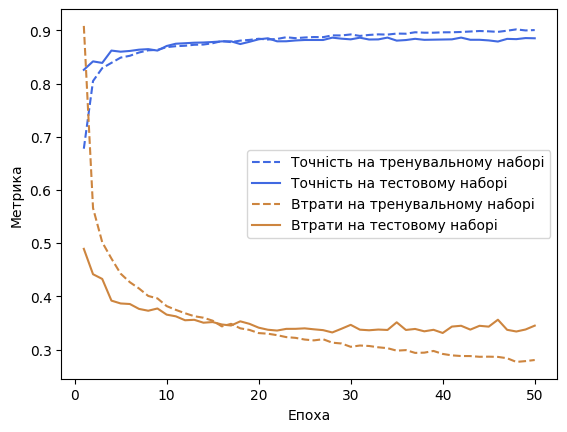

 Оптимальне значення параметра dropout_rate = 0.1
   точність на тестових даних: 0.8931999802589417

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9310 - loss: 0.1835
   тренувальні дані:   0.930733323097229 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8873 - loss: 0.3424
   тестові дані:       0.885699987411499 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


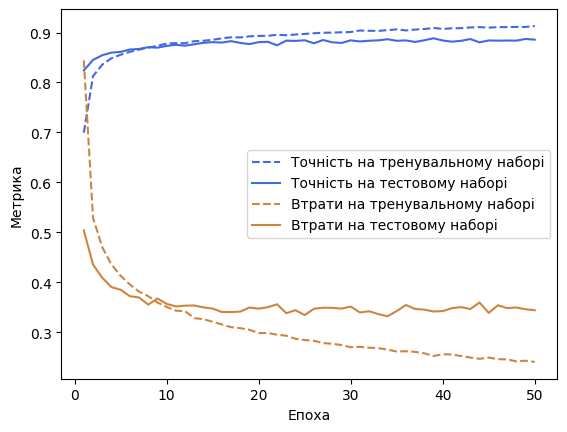

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9477 - loss: 0.1374
   тренувальні дані:   0.9467333555221558 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.8922 - loss: 0.3495
   тестові дані:       0.892300009727478 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


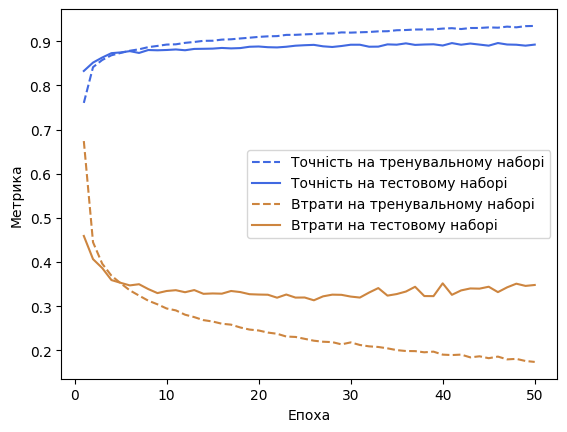

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.9591 - loss: 0.1056
   тренувальні дані:   0.9577500224113464 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8964 - loss: 0.3916
   тестові дані:       0.8974000215530396 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


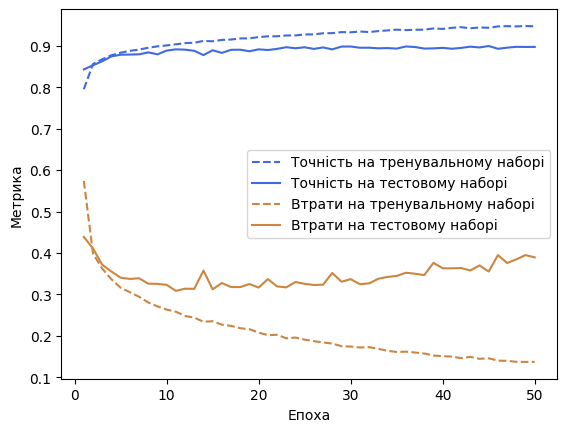

 Оптимальне значення параметра hidden_units = 256
   точність на тестових даних: 0.8974000215530396

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.9123 - loss: 0.2303
   тренувальні дані:   0.9122333526611328 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8848 - loss: 0.3324
   тестові дані:       0.8866000175476074 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


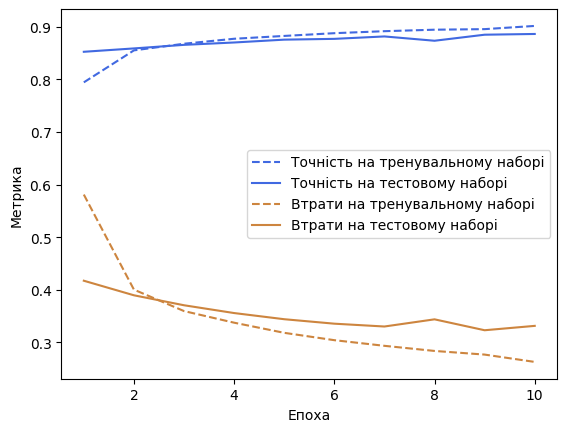

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9354 - loss: 0.1724
   тренувальні дані:   0.9346166849136353 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8916 - loss: 0.3134
   тестові дані:       0.890999972820282 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


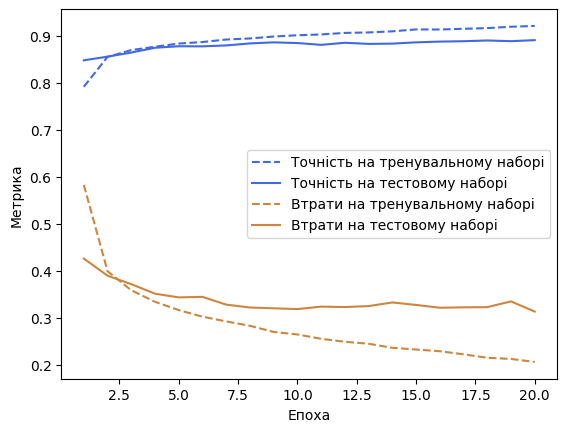

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.9571 - loss: 0.1144
   тренувальні дані:   0.9565333127975464 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8898 - loss: 0.3922
   тестові дані:       0.8896999955177307 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


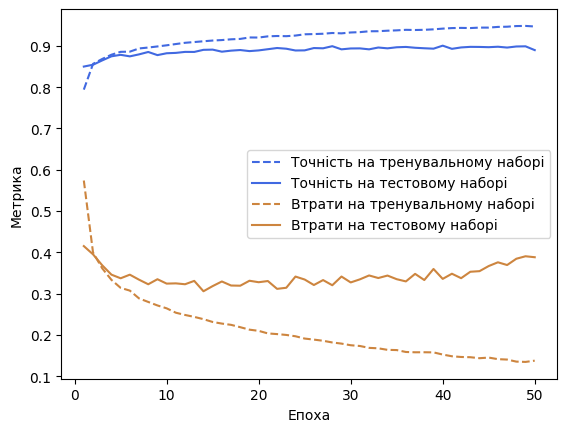

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9786 - loss: 0.0576
   тренувальні дані:   0.9780166745185852 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8938 - loss: 0.5080
   тестові дані:       0.8952999711036682 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


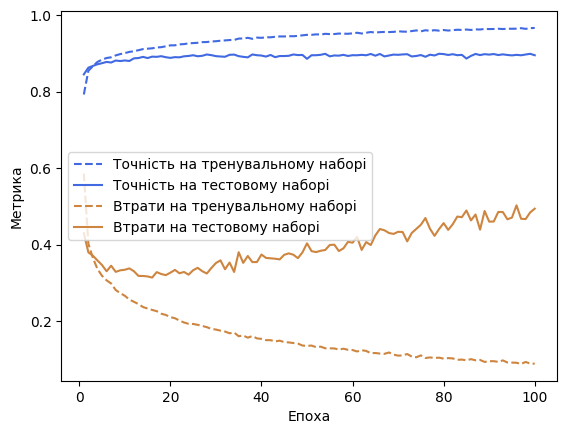

 Оптимальне значення параметра epochs = 50
   точність на тестових даних: 0.8974000215530396



In [238]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_2,
)

In [239]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8974000215530396


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>0.8923</b> до <b>0.8974</b>, при цьому втрати на тестових даних сягають 0.3916</p>
<p>Оптимальні параметри змінилися тільки в двох пунктах: <br>
1. dropout_rate було 0.2 стало 0.1<br>
2. hidden_units було 128 стало 256</p>
</div>

***
### **Модель для тренування 3** 
***

_модель підгледів в інтернеті_

In [240]:
def train_model_3(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0,
):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            Dense(512, activation=activation),
            Dropout(dropout_rate),
            Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

In [241]:
study_sequence = [
    # "batch_size",
    "optimizer",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    "activation",
    # "metrics",
    # "epochs",
]

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------


c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9988 - loss: 0.0038
          тренувальні дані:   0.9986833333969116 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9132 - loss: 0.6578
          тестові дані:       0.914900004863739 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


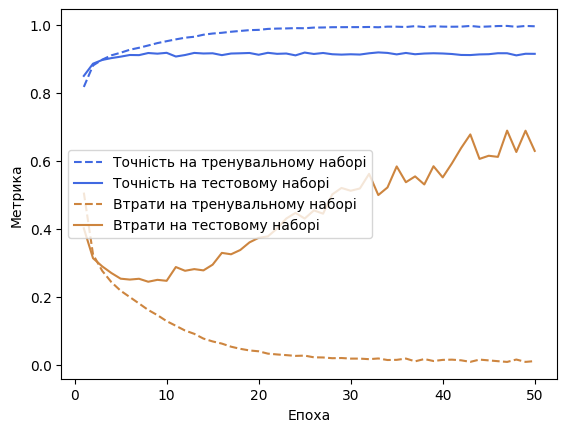

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9967 - loss: 0.0101
          тренувальні дані:   0.9966166615486145 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9090 - loss: 0.7695
          тестові дані:       0.9126999974250793 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


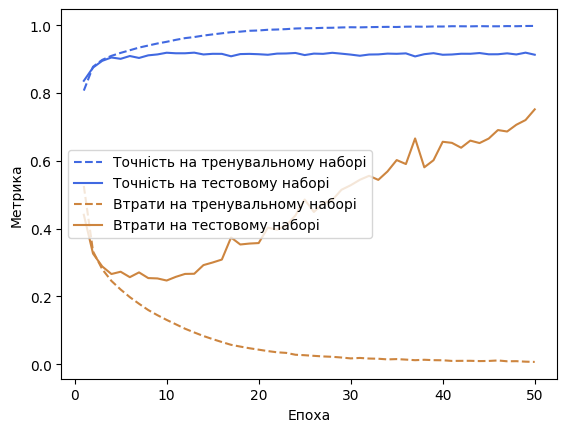

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9071 - loss: 0.2474
          тренувальні дані:   0.9065333604812622 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8868 - loss: 0.3195
          тестові дані:       0.8870999813079834 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


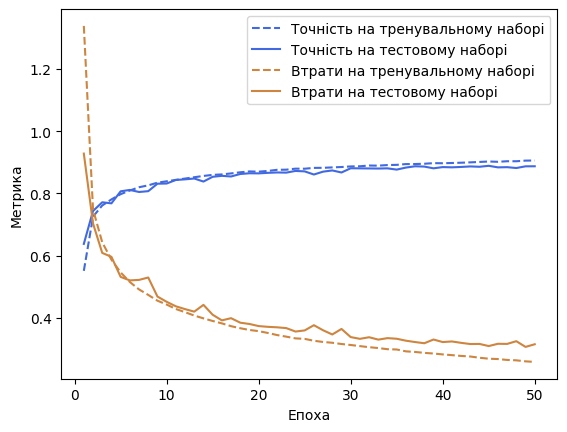

--------------------------------------------------
Тестується значення: optimizer = adagrad
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8547 - loss: 0.4163
          тренувальні дані:   0.8524166941642761 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8485 - loss: 0.4448
          тестові дані:       0.843500018119812 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adagrad
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


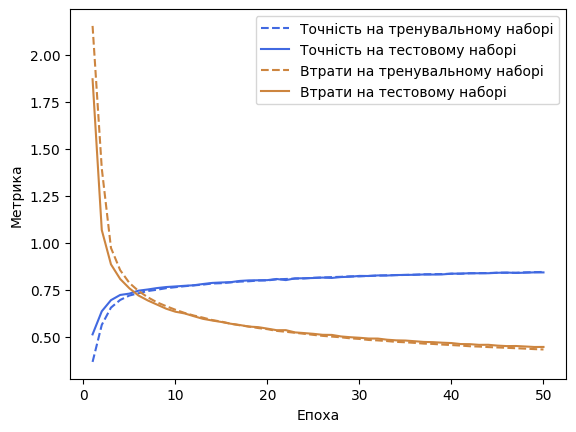

--------------------------------------------------
Тестується значення: optimizer = adadelta
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7632 - loss: 0.6738
          тренувальні дані:   0.7626833319664001 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7529 - loss: 0.6928
          тестові дані:       0.7534000277519226 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adadelta
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


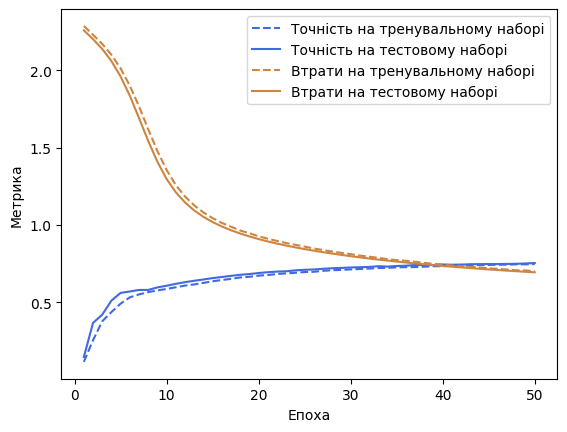

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.914900004863739

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9973 - loss: 0.0075
          тренувальні дані:   0.9975833296775818 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9122 - loss: 0.7139
          тестові дані:       0.9133999943733215 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


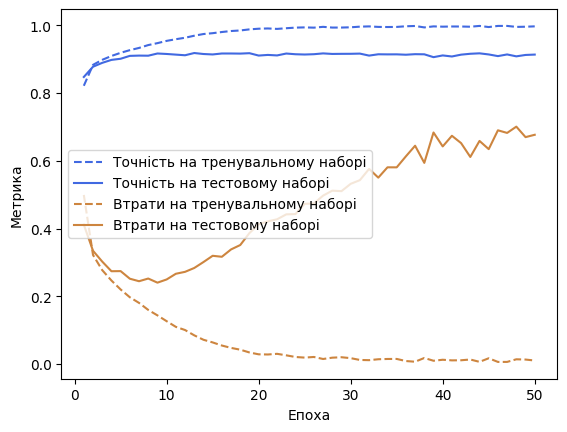

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9985 - loss: 0.0046
          тренувальні дані:   0.9983833432197571 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9157 - loss: 0.6660
          тестові дані:       0.9190000295639038 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


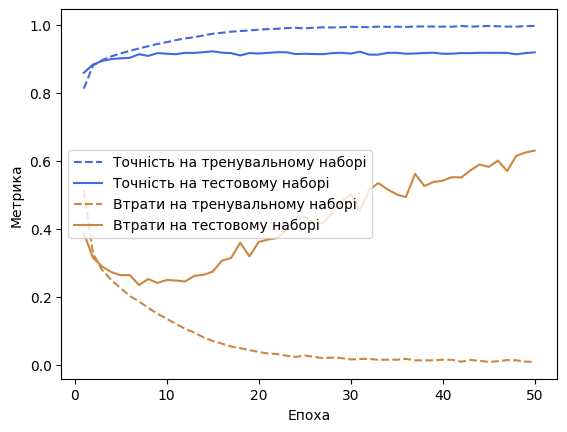

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9986 - loss: 0.0042
          тренувальні дані:   0.998533308506012 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9118 - loss: 0.6366
          тестові дані:       0.9154999852180481 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


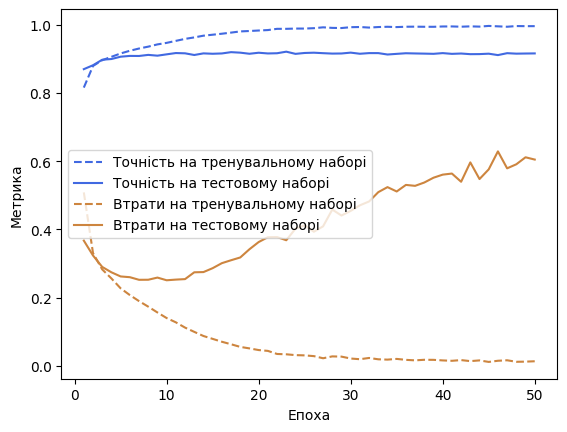

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9977 - loss: 0.0073
          тренувальні дані:   0.9977999925613403 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9138 - loss: 0.5897
          тестові дані:       0.9176999926567078 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


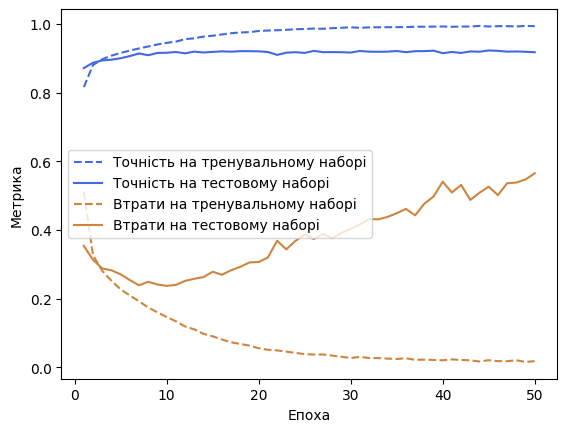

 Оптимальне значення параметра dropout_rate = 0.1
   точність на тестових даних: 0.9190000295639038

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9985 - loss: 0.0050
          тренувальні дані:   0.9984999895095825 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9123 - loss: 0.6472
          тестові дані:       0.9143999814987183 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


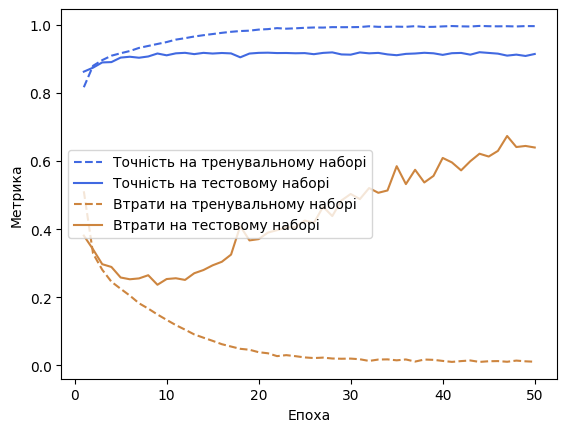

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9750 - loss: 0.0703
          тренувальні дані:   0.9739833474159241 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9040 - loss: 0.3217
          тестові дані:       0.9046000242233276 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= sigmoid
 metrics 	= ['accuracy']


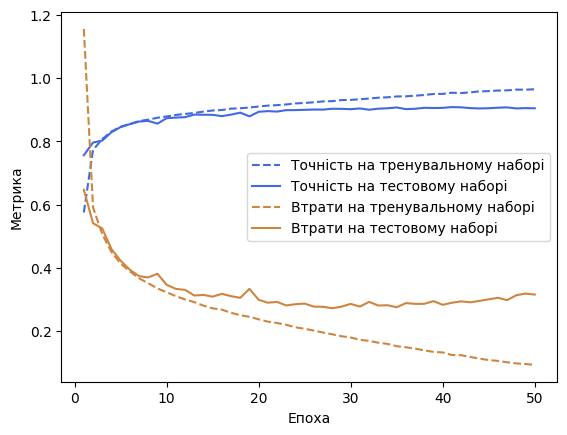

--------------------------------------------------
Тестується значення: activation = tanh
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9987 - loss: 0.0037
          тренувальні дані:   0.998533308506012 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9052 - loss: 0.6059
          тестові дані:       0.9065999984741211 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= tanh
 metrics 	= ['accuracy']


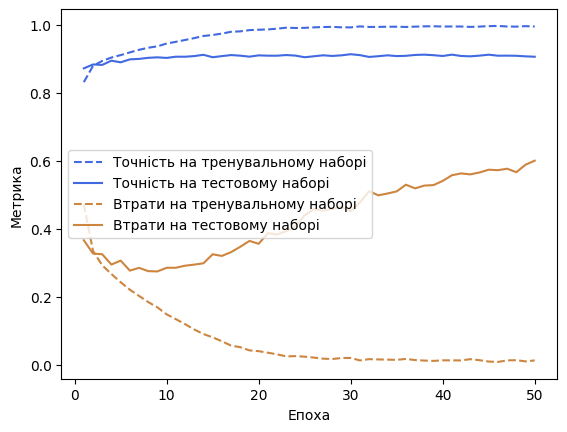

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9190000295639038



In [242]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_3,
)

In [243]:
print_parameters(best_parameters, "Оптимальні параметри для model_3")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_3
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9190000295639038


<div class="alert alert-block alert-info">
<b>Висновки model_3:</b> 
<p>Отримано оптимальні параметри для більш ускладненої моделі зі згортковими шарами<br>Вдалося досягнути максимального значення точності 0,919, але втрати на тестових даних становлять 0.6472<br>До того ж, оптимальні параметри залишились такими самими, як для model_2</p>
</div>